In [1]:
from keras.models import load_model
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from mediapipe.python.solutions import holistic

In [2]:
mp_drawing=mp.solutions.drawing_utils   #holistic model
mp_holistic=mp.solutions.holistic       #drawing utilities
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #color conversion BGR to RGB
    image.flags.writeable = False                   #Image is no longer writeable
    results = model.process(image)                  # make prediction
    image.flags.writeable = True                    #image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  #color conversion again RGB to BGR
    return image,results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #Draw right hand connections

def draw_style_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(175,13,13), thickness=1, circle_radius=1),   #color dot
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=1)    #color line
                              )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(178,16,16), thickness=2, circle_radius=4),   #color dot
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2)    #color line
                              )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=1),   #color dot
                              mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)    #color line
                              )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=1),   #color dot
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2)    #color line
                              )

def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.y,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x,res.y,res.y] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x,res.y,res.y] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.y] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

In [3]:
# actions=np.array(['Aausadi','Ambulance','Bathroom','Be Careful','Bleeding','Call','Dhanebad','Doctor','Dont Understand','Eklopan',
#                   'Emergency','Firstaid','Good Morning','Happy','Heart_attack','Hello','Help','Hospital','Name','Need','Nice To Meet You',
#                   'Oxygen','Pain','Please','Police','Relax','Sign','Slowly','Sorry','What','Yes','You'])
# actions=np.array(['Ambulance','Bathroom','Be Careful','Bleeding','Good Morning','Help','Name','Relax','Slowly','What'])
actions=np.array(['Dont Understand','Happy','Hello','Hospital','Nice To Meet You','Oxygen','Pain','Police','Yes','Sorry','चिकित्सक'])

# actions=np.array(['Ambulance','Bathroom','Be Careful','Bleeding','Good Morning','help','Name','Relax','Slowly'])

In [4]:
# model_path = r'C:\Users\Dell\Desktop\New folder\combile.h5'
# model_path = r'C:\Users\Dell\Desktop\New folder\combine.h5'
# model_path = r'C:\Users\Dell\Desktop\New folder\combinebilstm.h5'
# model_path = r'C:\Users\Dell\Desktop\New folder\handgesture-recognitioncnn.h5'
# model_path = r'models\Nimesh.h5'
model_path = r'D:\Hand Gesture Recognition\lstm2.h5'
# model_path = r'C:\Users\Dell\Downloads\1-7.h5'

# Load the model
loaded_model = load_model(model_path)

In [5]:
sequence = []
sentence = []
predictions = []
threshold = 0.9

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        # make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)

        # Draw landmarks
        # draw_landmarks(image, results)  # default landmarks in face hand

        draw_style_landmarks(image, results)  # customized landmarks in face and hand

        # prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        # sequence.insert(0, keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = loaded_model.predict(np.expand_dims(sequence, axis=0))[0]
            # print(actions[np.argmax(res)])
            # print("Confidence values:", res)
            print("Predicted Action:", actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # visualization logic
            if np.unique(predictions[-30:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 3:
                sentence = sentence[-3:]

        # viz probabilities
            # image = prob_viz(res,actions,image,colors)

        image = cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        image = cv2.flip(image, 1)
        image = cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                            cv2.LINE_AA)
        # show to screen
        cv2.imshow('OPENCV FEED', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 1s 724ms/step
Predicted Action: Yes
1/1 [==============================] - 0s 52ms/step
Predicted Action: Police
1/1 [==============================] - 0s 66ms/step
Predicted Action: Yes
1/1 [==============================] - 0s 58ms/step
Predicted Action: Police
1/1 [==============================] - 0s 56ms/step
Predicted Action: Police
1/1 [==============================] - 0s 52ms/step
Predicted Action: Police
1/1 [==============================] - 0s 49ms/step
Predicted Action: Police
1/1 [==============================] - 0s 53ms/step
Predicted Action: Police
1/1 [==============================] - 0s 51ms/step
Predicted Action: Police
1/1 [==============================] - 0s 61ms/step
Predicted Action: चिकित्सक
1/1 [==============================] - 0s 51ms/step
Predicted Action: Police
1/1 [==============================] - 0s 60ms/step
Predicted Action: Hospital
1/1 [==============================] - 0s 60ms/step
Predicted Action: Police


In [9]:
import cv2
import mediapipe as mp
import numpy as np
import time

# Define your functions and variables for mediapipe, model, actions, and colors here

sequence = []
sentence = []
predictions = []
confi=[]
display=[]
threshold = 0.9

cap = cv2.VideoCapture(0)

# Variables for FPS calculation
start_time = time.time()
frame_count = 0
fps=0
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # FPS calculation
        frame_count += 1
        if time.time() - start_time >= 1:
            fps = frame_count / (time.time() - start_time)
            frame_count = 0
            start_time = time.time()

        # make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        # draw_landmarks(image, results)  # default landmarks in face hand
        draw_style_landmarks(image, results)  # customized landmarks in face and hand

        # prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = loaded_model.predict(np.expand_dims(sequence, axis=0))[0]
            print("Predicted Action:", actions[np.argmax(res)])
            res_value = max(res)
            res_2d = [[res_value, res_value]]  # Duplicate the value to create a 2D array
            # Append the new max(res) value to the confi and display lists
            confi.append(res_2d)  
            np.save('confi.npy', np.array(confi)) 
            # print(confi)
            predictions.append(np.argmax(res))

            # visualization logic
            if np.unique(predictions[-20:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    res_value = max(res)
                    res_2d = [[res_value, res_value]]  # Duplicate the value to create a 2D array
                    # Append the new max(res) value to the confi and display lists
                    display.append(res_2d)
                    np.save('display.npy', np.array(display))
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 3:
                sentence = sentence[-3:]

        # Viz probabilities
        # image = prob_viz(res,actions,image,colors)

        # Display FPS on the screen
        image = cv2.flip(image, 1)
        cv2.putText(image, f"FPS: {round(fps, 2)}", (0,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Draw sentence on the image
        image = cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        image = cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show the frame on the screen
        cv2.imshow('OPENCV FEED', image)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Release the webcam and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 168ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 164ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 171ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 169ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 169ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 165ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 166ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 180ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 174ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 172ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 174ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0s 172ms/step
Predicted Action: Bathroom
1/1 [==============================] - 0

In [20]:
len(np.load('D:\Hand Gesture Recognition\display.npy'))

184

In [7]:
len(np.load('D:\Hand Gesture Recognition\confi.npy'))

354

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from confi.npy and display.npy
confi_data = np.load('confi.npy')
display_data = np.load('display.npy')

# Extract x and y coordinates for confi.npy
confi_x = np.arange(len(confi_data))  # Generating x values as indices
confi_y = confi_data[:, 0]  # Using the only value available

# Extract x and y coordinates for display.npy
display_x = np.arange(len(display_data))  # Generating x values as indices
display_y = display_data[:, 0]  # Using the only value available

# Plot graph for confi.npy
plt.figure(figsize=(8, 6))
plt.plot(confi_x, confi_y, label='Confidence', color='blue')  
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Graph of Confidence from confi.npy')
plt.legend()
plt.grid(True)
plt.show()

# Plot graph for display.npy
plt.figure(figsize=(8, 6))
plt.plot(display_x, display_y, label='Display', color='red')  
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Graph of Display from display.npy')
plt.legend()
plt.grid(True)
plt.show()


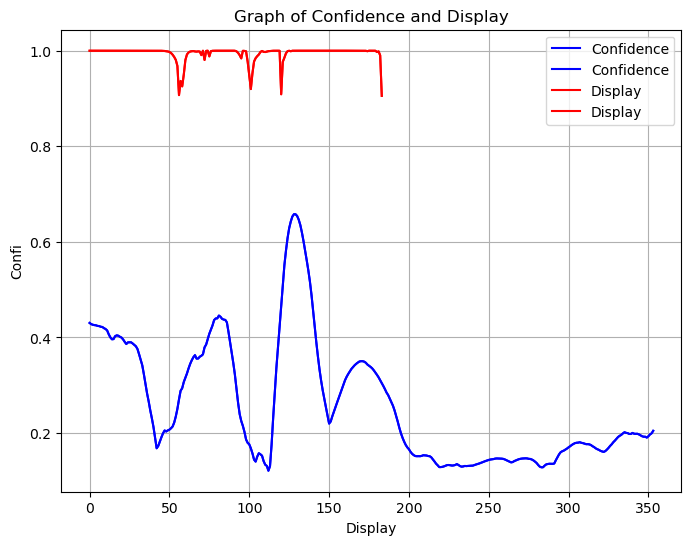

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from confi.npy and display.npy
confi_data = np.load('confi.npy')
display_data = np.load('display.npy')

# Extract x and y coordinates for confi.npy
confi_x = np.arange(len(confi_data))  # Generating x values as indices
confi_y = confi_data[:, 0]  # Using the only value available

# Extract x and y coordinates for display.npy
display_x = np.arange(len(display_data))  # Generating x values as indices
display_y = display_data[:, 0]  # Using the only value available

# Plot both graphs in the same figure
plt.figure(figsize=(8, 6))

# Plot graph for confi.npy
plt.plot(confi_x, confi_y, label='Confidence', color='blue')  

# Plot graph for display.npy
plt.plot(display_x, display_y, label='Display', color='red')  

plt.xlabel('Display')
plt.ylabel('Confi')
plt.title('Graph of Confidence and Display')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
cap.release()
cv2.destroyAllWindows()

In [10]:
max(res)

0.2655841

In [11]:
np.unique(predictions[-10:])[0]

4

In [12]:
res

array([0.01909848, 0.11086985, 0.16514972, 0.07635555, 0.2655841 ,
       0.07097762, 0.19978471, 0.05723116, 0.03494881], dtype=float32)

In [13]:
np.argmax(res)

4

In [14]:
res[np.argmax(res)] > threshold

False

In [15]:
res[np.argmax(res)]

0.2655841

In [16]:
len(sentence)

0

In [17]:
len(sentence) > 0

False

In [18]:
len(sequence) == 60

True

In [19]:
sentence

[]

In [ ]:
actions[np.argmax(res)]

In [ ]:
print("Argmax index:", np.argmax(res))
print("Length of actions list:", len(actions))


In [ ]:
actions[np.argmax(res)] != sentence[-1]